In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [58]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)



In [59]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())


Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [60]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4186, 4177, 4214, 4217, 4208, 4126, 4264, 4234, 4223, 4151]
test groups: [1814, 1823, 1786, 1783, 1792, 1874, 1736, 1766, 1777, 1849]


In [61]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)


In [62]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='InceptionV1Input')
n_layer = img_in

layer_1 = Conv2D(64, (1,1), padding='same', activation='relu')(n_layer)
layer_1 = Conv2D(64, (3,3), padding='same', activation='relu')(layer_1)
layer_2 = Conv2D(64, (1,1), padding='same', activation='relu')(n_layer)
layer_2 = Conv2D(64, (5,5), padding='same', activation='relu')(layer_2)
layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(n_layer)
layer_3 = Conv2D(64, (1,1), padding='same', activation='relu')(layer_3)

output = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
output = Flatten()(output)
out = Dense(10, activation='relu')(output)

feature_model = Model(inputs=[img_in], outputs=[out], name='InceptionV1Model')
feature_model.summary()


Model: "InceptionV1Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InceptionV1Input (InputLayer)  [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_122 (Conv2D)            (None, 28, 28, 64)   128         ['InceptionV1Input[0][0]']       
                                                                                                  
 conv2d_124 (Conv2D)            (None, 28, 28, 64)   128         ['InceptionV1Input[0][0]']       
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 28, 28, 1)   0           ['InceptionV1Input[0][0]']       
 )                                                                                 

In [63]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()



Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 InceptionV1Model (Functional)  (None, 10)           1645066     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['InceptionV1Model

In [64]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
metrics = ['mae'])


In [65]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch = 300,
                                              validation_data=([valid_a, valid_b],valid_sim),
                                            epochs = 8,
                                            verbose = True)


Epoch 1/8


C:\Users\danyl\AppData\Local\Temp\ipykernel_1708\1366532195.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(siam_gen(train_groups),


300/300 [==============================] - 102s 336ms/step - loss: 0.5762 - mae: 0.4054 - val_loss: 0.5049 - val_mae: 0.3707
Epoch 2/8
300/300 [==============================] - 103s 344ms/step - loss: 0.4748 - mae: 0.3504 - val_loss: 0.4597 - val_mae: 0.3346
Epoch 3/8
300/300 [==============================] - 100s 332ms/step - loss: 0.4255 - mae: 0.3131 - val_loss: 0.4102 - val_mae: 0.2959
Epoch 4/8
300/300 [==============================] - 104s 346ms/step - loss: 0.3854 - mae: 0.2822 - val_loss: 0.3707 - val_mae: 0.2632
Epoch 5/8
300/300 [==============================] - 101s 337ms/step - loss: 0.3652 - mae: 0.2617 - val_loss: 0.3609 - val_mae: 0.2514
Epoch 6/8
300/300 [==============================] - 102s 341ms/step - loss: 0.3476 - mae: 0.2444 - val_loss: 0.3550 - val_mae: 0.2509
Epoch 7/8
300/300 [==============================] - 103s 344ms/step - loss: 0.3164 - mae: 0.2225 - val_loss: 0.3340 - val_mae: 0.2262
Epoch 8/8
300/300 [==============================] - 102s 340ms/s

In [69]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose =
True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose
= True, batch_size = 128)


141/141 [==============================] - 44s 311ms/step


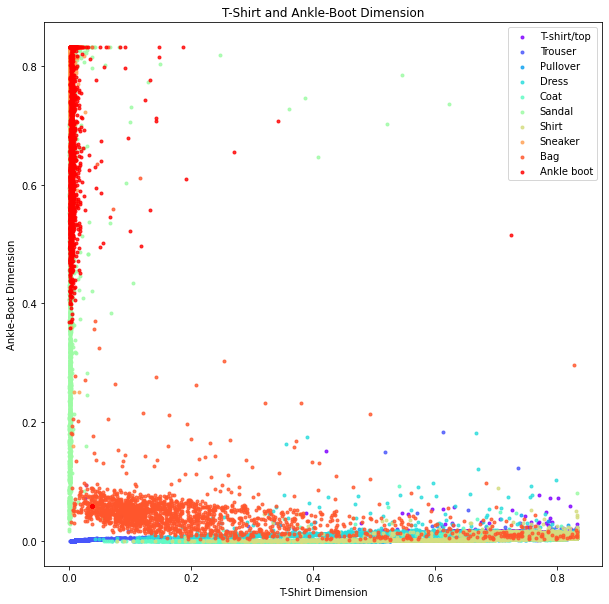

In [70]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)


In [66]:
x_test_features = feature_model.predict(x_test, verbose = True,batch_size=128)


141/141 [==============================] - 24s 169ms/step


In [67]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
            init='pca',
            random_state=101,
            method='barnes_hut',
            n_iter=500,
            verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.063s...


c:\users\danyl\pycharmprojects\computervision\server\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 18000 samples in 0.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sample 13000 / 18000
[t-SNE] Computed conditional probabilities for sample 14000 / 18000

c:\users\danyl\pycharmprojects\computervision\server\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 59.0093498, gradient norm = 0.0061373 (50 iterations in 3.286s)
[t-SNE] Iteration 100: error = 60.9776306, gradient norm = 0.0035999 (50 iterations in 3.140s)
[t-SNE] Iteration 150: error = 62.4834518, gradient norm = 0.0029229 (50 iterations in 3.070s)
[t-SNE] Iteration 200: error = 63.9160690, gradient norm = 0.0025138 (50 iterations in 2.958s)
[t-SNE] Iteration 250: error = 64.4994736, gradient norm = 0.0014012 (50 iterations in 3.043s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.499474
[t-SNE] Iteration 300: error = 2.0137122, gradient norm = 0.0010542 (50 iterations in 3.000s)
[t-SNE] Iteration 350: error = 1.6650648, gradient norm = 0.0004826 (50 iterations in 2.966s)
[t-SNE] Iteration 400: error = 1.5033745, gradient norm = 0.0003000 (50 iterations in 3.034s)
[t-SNE] Iteration 450: error = 1.4048259, gradient norm = 0.0002203 (50 iterations in 2.969s)
[t-SNE] Iteration 500: error = 1.3334332, gradient norm = 0.0001766 (50 

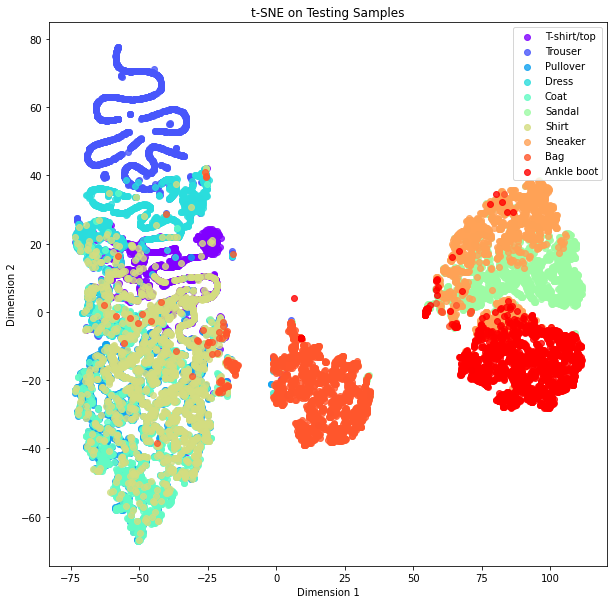

In [68]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)
